In [1]:
import os
import joblib
import optuna
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler
import optuna.visualization as vis
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, KFold


c:\Users\aadi2\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
Path_Data = '3_merged_data3.txt'
df = pd.read_csv(f"{Path_Data}", sep='\t')


In [3]:
# Separate features and target
X = df.drop(columns=['ID', 'avg7_calingiri'])
y = df['avg7_calingiri']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2,  random_state=42
)

print(f"X_train shape: {X_train.shape}")  # 80%
print(f"X_test shape: {X_test.shape}")    # 20%


X_train shape: (119, 33048)
X_test shape: (30, 33048)


In [4]:
def objective(trial, estimator_class, param_space, X, y, cv):
    # Suggest parameters for current trial based on param_space dict
    params = {}
    for param_name, param_range in param_space.items():
        if isinstance(param_range, tuple):  # Let's define range as tuples (low, high)
            low, high = param_range
            if isinstance(low, int) and isinstance(high, int):
                params[param_name] = trial.suggest_int(param_name, low, high)
            else:
                params[param_name] = trial.suggest_float(param_name, low, high, log=True)
        elif isinstance(param_range, list):
            params[param_name] = trial.suggest_categorical(param_name, param_range)
        else:
            raise ValueError(f"Unknown param range type for {param_name}")
    
    model = estimator_class(**params)
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model)
    ])

    # Use neg MSE as scoring so we maximize
    scores = cross_val_score(pipe, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
    # Return mean score for Optuna to maximize
    return scores.mean()

import time

def train_with_optuna(model_name, estimator_class, param_space, X_train, y_train, k=3, n_trials=50):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    start_time = time.time()
    
    study = optuna.create_study(direction='maximize')
    func = lambda trial: objective(trial, estimator_class, param_space, X_train, y_train, kf)
    study.optimize(func, n_trials=n_trials, n_jobs=1, show_progress_bar=False)
    
    best_params = study.best_params
    best_model = estimator_class(**best_params)
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", best_model)
    ])
    pipe.fit(X_train, y_train)
    
    elapsed_time = time.time() - start_time

    # Save model
    safe_model_name = f"{model_name.replace(' ', '_')}_K{k}_optuna"
    os.makedirs("saved_models_optuna", exist_ok=True)
    joblib.dump(pipe, f"saved_models_optuna/{safe_model_name}.pkl")
    
    # Predict & metrics on training set
    y_train_pred = pipe.predict(X_train)
    mse = mean_squared_error(y_train, y_train_pred)
    mae = mean_absolute_error(y_train, y_train_pred)
    r2 = r2_score(y_train, y_train_pred)
    
    return {
        "Model": f"{model_name} (K={k})",
        "Best Params": best_params,
        "MSE": mse,
        "Study": study, 
        "MAE": mae,
        "R2": r2,
                "Training Time (s)": elapsed_time,

        "Trials": study.trials_dataframe()
    }

In [ ]:
search_spaces_optuna = {
    "Decision Tree": {
        "estimator": DecisionTreeRegressor,
        "params": {
            "max_depth": (2, 10),          # integer range
            "min_samples_split": (2, 10)  # integer range
        }
    },
    "Random Forest": {
        "estimator": RandomForestRegressor,
        "params": {
            "n_estimators": (50, 150),    # integer range
            "max_depth": (2, 10),
            "min_samples_split": (2, 10)
        }
    },
    "Lasso Regression": {
        "estimator": Lasso,
        "params": {
            "alpha": (1e-4, 10.0)         # float range (log scale)
        }
    },
    "Gradient Boosting": {
        "estimator": GradientBoostingRegressor,
        "params": {
            "n_estimators": (50, 200),
            "max_depth": (2, 8),
            "learning_rate": (0.01, 0.3),   # float range
            "subsample": (0.5, 1.0)         # float range
        }
    },
    "Linear Regression": {
        "estimator": LinearRegression,
        "params": {
        }
    },
    "XGBoost": {
        "estimator": xgb.XGBRegressor,
        "params": {
            "n_estimators": (50, 200),
            "max_depth": (2, 10),
            "learning_rate": (0.01, 0.3),
            "subsample": (0.5, 1.0),
            "colsample_bytree": (0.5, 1.0)
        }
    }
}

In [9]:
results = []
best_results = {}

for model_name, model_info in tqdm(search_spaces_optuna.items(), desc="Model Families"):
    for k in [3, 5, 7]:
        # Run training with Optuna, but keep verbosity off inside train_with_optuna
        res = train_with_optuna(
            model_name=model_name,
            estimator_class=model_info["estimator"],
            param_space=model_info["params"],
            X_train=X_train,
            y_train=y_train,
            k=k,
            n_trials=50
        )
        
        results.append(res)
        
        # Keep track of the best model per (model_name, k) based on R2 score
        key = (model_name, k)
        if key not in best_results or res["R2"] > best_results[key]["R2"]:
            best_results[key] = res

# Now print only the best results summary per model and k
print("\nBest Models Summary:\n")
for (model_name, k), res in sorted(best_results.items()):
    print(f"Model: {model_name} | K-Folds: {k}")
    print(f"Best Params: {res['Best Params']}")
    print(f"MSE: {res['MSE']:.4f} | MAE: {res['MAE']:.4f} | R2: {res['R2']:.4f}")
    print(f"Training Time (s): {res['Training Time (s)']:.2f}")
    print("-" * 50)


Model Families:   0%|          | 0/2 [00:00<?, ?it/s][I 2025-05-31 10:21:19,146] A new study created in memory with name: no-name-eee4dc30-0a70-4aec-8ff2-413539710fc8
[I 2025-05-31 10:21:21,123] Trial 0 finished with value: -2.3406603804704003 and parameters: {'alpha': 0.003246426596097123}. Best is trial 0 with value: -2.3406603804704003.
[I 2025-05-31 10:21:22,067] Trial 1 finished with value: -2.0895850786045305 and parameters: {'alpha': 0.05454232982862997}. Best is trial 1 with value: -2.0895850786045305.
[I 2025-05-31 10:21:24,054] Trial 2 finished with value: -2.316933753442859 and parameters: {'alpha': 0.008267994638444184}. Best is trial 1 with value: -2.0895850786045305.
[I 2025-05-31 10:21:25,184] Trial 3 finished with value: -2.0335313716428947 and parameters: {'alpha': 0.07207349911030816}. Best is trial 3 with value: -2.0335313716428947.
[I 2025-05-31 10:21:27,100] Trial 4 finished with value: -2.3938883388709975 and parameters: {'alpha': 0.000229893830504038}. Best is tr


Best Models Summary:

Model: Lasso Regression | K-Folds: 3
Best Params: {'alpha': 0.40936154462310437}
MSE: 1.5438 | MAE: 1.0230 | R2: 0.0412
Training Time (s): 45.60
--------------------------------------------------
Model: Lasso Regression | K-Folds: 5
Best Params: {'alpha': 0.37033914018148417}
MSE: 1.4838 | MAE: 0.9987 | R2: 0.0785
Training Time (s): 57.64
--------------------------------------------------
Model: Lasso Regression | K-Folds: 7
Best Params: {'alpha': 0.2356508271265808}
MSE: 1.1133 | MAE: 0.8573 | R2: 0.3086
Training Time (s): 76.62
--------------------------------------------------
Model: Linear Regression | K-Folds: 3
Best Params: {}
MSE: 0.0000 | MAE: 0.0000 | R2: 1.0000
Training Time (s): 41.55
--------------------------------------------------
Model: Linear Regression | K-Folds: 5
Best Params: {}
MSE: 0.0000 | MAE: 0.0000 | R2: 1.0000
Training Time (s): 57.73
--------------------------------------------------
Model: Linear Regression | K-Folds: 7
Best Params: {

In [10]:
df_results = pd.DataFrame(results)


In [11]:
# Example: visualize from results
study = results[0]["Study"]  # Pick any model

# 1. Optimization History (MSE over trials)
vis.plot_optimization_history(study).show()

# 2. Hyperparameter Importance
vis.plot_param_importances(study).show()

# 3. Parallel Coordinates Plot
vis.plot_parallel_coordinate(study).show()

# 4. Slice Plot (effect of individual params on score)
vis.plot_slice(study).show()

# 5. Contour Plot (for interactions between two params)
vis.plot_contour(study).show()


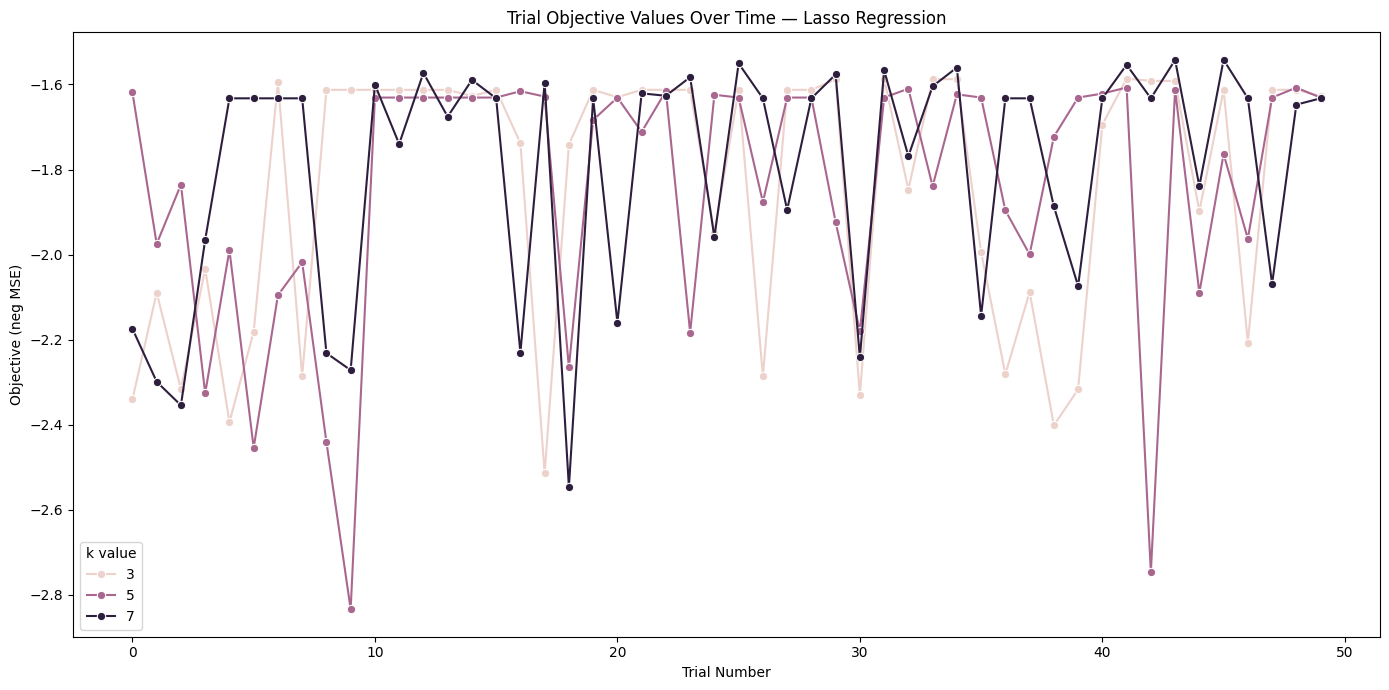

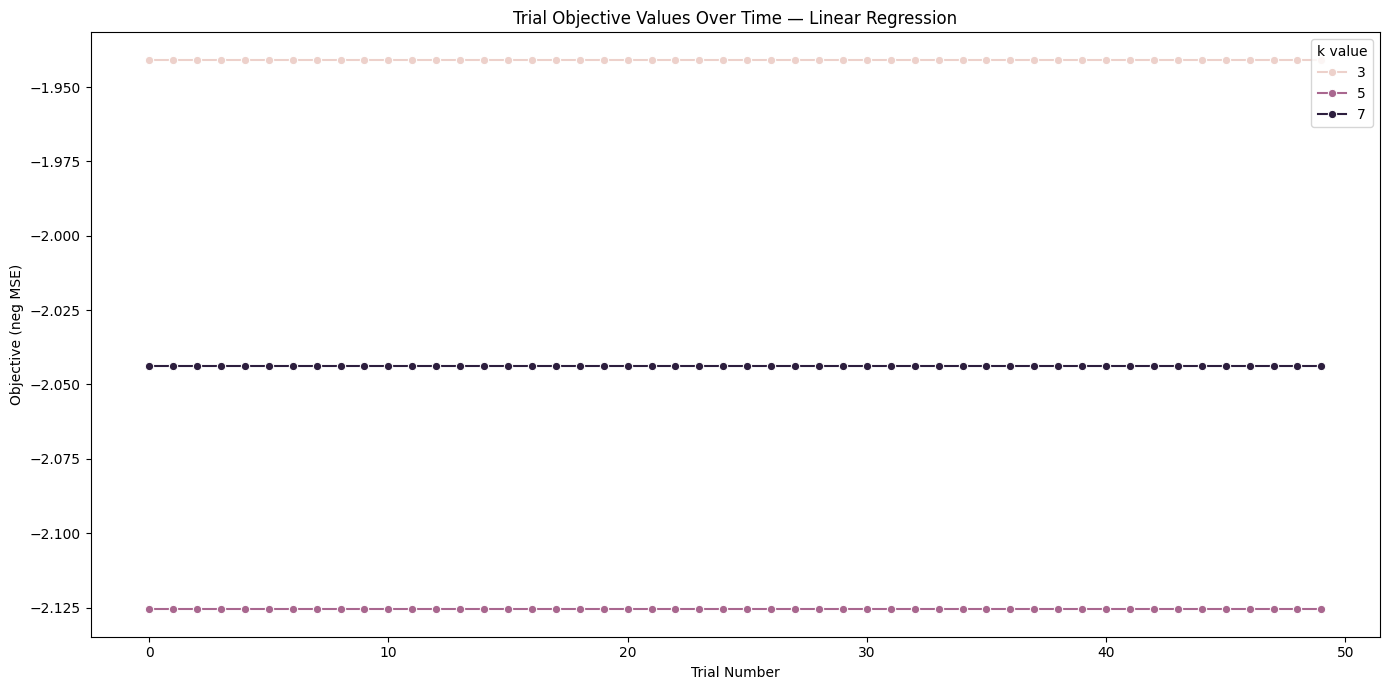

In [25]:
# First, expand all trials with model info
all_trials = []

for _, row in df_results.iterrows():
    df_temp = row["Trials"].copy()
    df_temp["Model_full"] = row["Model"]  # full string like "Lasso Regression (K=3)"
    all_trials.append(df_temp)

df_all = pd.concat(all_trials, ignore_index=True)

# Extract model family and k from Model_full string
import re

def extract_info(model_str):
    # Example input: "Lasso Regression (K=3)"
    match = re.match(r"(.+?)\s+\(K=(\d+)\)", model_str)
    if match:
        return match.group(1), int(match.group(2))
    else:
        # fallback if no match found
        return model_str, None

df_all[["Model", "k"]] = df_all["Model_full"].apply(lambda x: pd.Series(extract_info(x)))

# Now plot for each model family, showing lines for different k
import matplotlib.pyplot as plt
import seaborn as sns

model_families = df_all["Model"].unique()

for model in model_families:
    plt.figure(figsize=(14, 7))
    df_subset = df_all[df_all["Model"] == model]
    sns.lineplot(data=df_subset, x="number", y="value", hue="k", marker="o")
    plt.title(f"Trial Objective Values Over Time — {model}")
    plt.xlabel("Trial Number")
    plt.ylabel("Objective (neg MSE)")
    plt.legend(title="k value")
    plt.tight_layout()
    plt.show()


###  Distribution of Objective Values

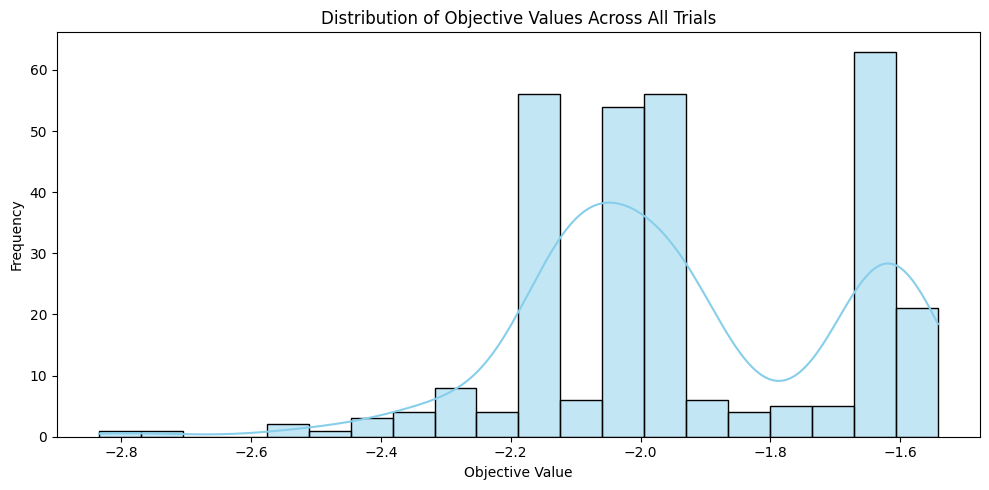

In [13]:
all_trials_df = pd.concat([res["Trials"] for res in results], ignore_index=True)

plt.figure(figsize=(10,5))
sns.histplot(all_trials_df["value"], bins=20, kde=True, color='skyblue')
plt.title("Distribution of Objective Values Across All Trials")
plt.xlabel("Objective Value")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


###  Alpha vs Performance (from Optuna Trials)

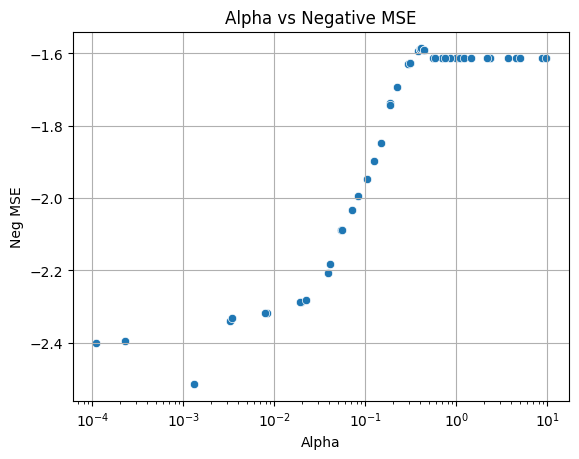

In [14]:
# Assuming you have optuna study object
df_trials = study.trials_dataframe()
sns.scatterplot(data=df_trials, x='params_alpha', y='value')
plt.title('Alpha vs Negative MSE')
plt.xlabel('Alpha')
plt.ylabel('Neg MSE')
plt.xscale('log')
plt.grid(True)
plt.show()
